In [1]:
import ee
import geemap.core as geemap
import geopandas as gpd
import pandas as pd
import fiona

import matplotlib.pyplot as plt
import seaborn as sns

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

### Settings

In [2]:
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default
ee.Authenticate()

True

In [3]:
ee.Initialize()

## Process

1. Define a two regions of interest (forest / agricultural field) and timeframe
2. Define a dataset of interest
3. Generate an ee ImageCollection for the area and timeframe
4. Use band math to create VIs
5. Plot timeseries
6. Generate smoothed curves
7. Create features from curves

## Problem Statement

Let's explore the differneces in NDVI and EVI for two different forests in the United States - a dry, conifer dominated forest in the Pacific Northwest vs. a broadleaf community in the Midwest

#### ROI - Region of Interest

In [4]:
## Import US State Boundaries
us_states = gpd.read_file('/Users/ryangeygan/Downloads/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

xmin, ymin, xmax, ymax = -129.37, 24.53, -65.30, 48.67

conus = us_states.cx[xmin:xmax, ymin:ymax]

## Import a couple self defined shapefiles for forest patches

pine_forest = gpd.read_file('/Users/ryangeygan/Downloads/mountain_pine_wa.kml')
temperate_broadleaf = gpd.read_file('/Users/ryangeygan/Downloads/broadleaf_wi.kml')

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_10659/3328174610.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wa_centriod = pine_forest.to_crs(epsg='4326').centroid
/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_10659/3328174610.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wi_centriod = temperate_broadleaf.to_crs(epsg='4326').centroid


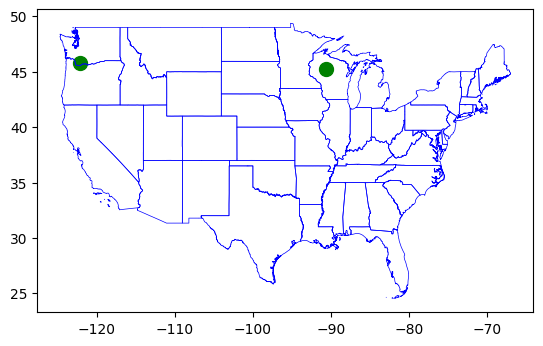

In [5]:
# Plot GeoDataFrame 1 with the boundaries
ax = conus.to_crs(epsg='4326').boundary.plot(color='blue', linewidth=0.5)

# Plot GeoDataFrame 2 centroids
wa_centriod = pine_forest.to_crs(epsg='4326').centroid
wa_centriod.plot(ax=ax, color='green', markersize=100)

# Plot GeoDataFrame 3 centroids
wi_centriod = temperate_broadleaf.to_crs(epsg='4326').centroid
wi_centriod.plot(ax=ax, color='green', markersize=100)

# Show the plot
plt.show()

### Get Harmonized Landsat Sentinel

Let's get the imagery for 5 seasons from spring 2018 to fall 2023

In [6]:
start_date = '2018-01-01'
end_date = '2023-12-31'

In [7]:
## For the Pine Forest

col1 = ee.ImageCollection("NASA/HLS/HLSL30/v002").filter(ee.Filter.date(start_date, end_date)).filterBounds(
    ee.Geometry.Point(wa_centriod.x[0], wa_centriod.y[0])).filter(ee.Filter.lessThan('CLOUD_COVERAGE', 30))

col2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filter(ee.Filter.date(start_date, end_date)).filterBounds(
    ee.Geometry.Point(wa_centriod.x[0], wa_centriod.y[0])).filter(ee.Filter.lessThan('CLOUDY_PIXEL_PERCENTAGE', 30))

## For the Broadleaf Forest

col3 = ee.ImageCollection("NASA/HLS/HLSL30/v002").filter(ee.Filter.date(start_date, end_date)).filterBounds(
    ee.Geometry.Point(wi_centriod.x[0], wi_centriod.y[0])).filter(ee.Filter.lessThan('CLOUD_COVERAGE', 30))

col4 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filter(ee.Filter.date(start_date, end_date)).filterBounds(
    ee.Geometry.Point(wi_centriod.x[0], wi_centriod.y[0])).filter(ee.Filter.lessThan('CLOUDY_PIXEL_PERCENTAGE', 30))

### Functions to Prepare the Imagery

In [8]:
def create_ndvi_band_OLI(image):
    "Takes a Landsat image and returns the Normalized Difference Vegetation Index"

    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    
    return image.addBands(ee.Image(ndvi))

def create_ndvi_band_MSI(image):
    "Takes a Sentinel image and returns the Normalized Difference Vegetation Index"

    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    
    return image.addBands(ee.Image(ndvi))

def cloud_mask_OLI(image):
    "Updates the mask for an image setting clouds and cloud shadow to zero for Landsat 8/9"

    qa = image.select('Fmask')
    
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloud_bit_mask = 1 << 4
    cloud_shadow_bit_mask = 1 << 2
    
    # Both flags should be set to zero, indicating clear conditions.
    mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0))
    )
    
    return image.updateMask(mask)

    return image

def cloud_mask_MSI(image):
    "Updates the mask for an image setting clouds and cloud shadow to zero for Sentinel 2"

    qa = image.select('QA60')
    
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    
    # Both flags should be set to zero, indicating clear conditions.
    mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )
    
    return image.updateMask(mask)

def get_90p_ndvi_wa(image):

    geometry = ee.Geometry.Rectangle(list(pine_forest.bounds.iloc[0]))

    return ee.Image(image).reduceRegion(ee.Reducer.percentile([80]), geometry).get('NDVI')

def get_90p_ndvi_wi(image):

    geometry = ee.Geometry.Rectangle(list(temperate_broadleaf.bounds.iloc[0]))

    return ee.Image(image).reduceRegion(ee.Reducer.percentile([80]), geometry).get('NDVI')

def add_z_score(group):
    group['z_score'] = np.abs(stats.zscore(group.ndvi))
    return group


In [9]:
landsat_clean_ndvi_wa = col1.map(create_ndvi_band_OLI).map(cloud_mask_OLI)

msi_clean_ndvi_wa = col2.map(create_ndvi_band_MSI).map(cloud_mask_MSI)

landsat_clean_ndvi_wi = col3.map(create_ndvi_band_OLI).map(cloud_mask_OLI)

msi_clean_ndvi_wi = col4.map(create_ndvi_band_MSI).map(cloud_mask_MSI)

In [10]:
image_list1 = landsat_clean_ndvi_wa.toList(landsat_clean_ndvi_wa.size())

image_list2 = msi_clean_ndvi_wa.toList(msi_clean_ndvi_wa.size())

foo1 = image_list1.map(get_90p_ndvi_wa).getInfo()

foo2 = image_list2.map(get_90p_ndvi_wa).getInfo()

image_list3 = landsat_clean_ndvi_wi.toList(landsat_clean_ndvi_wi.size())

image_list4 = msi_clean_ndvi_wi.toList(msi_clean_ndvi_wi.size())

foo3 = image_list3.map(get_90p_ndvi_wi).getInfo()

foo4 = image_list4.map(get_90p_ndvi_wi).getInfo()

### Crude Way to Get Dates of Imagery and Create the NDVI DataFrame

In [12]:
dates1 = []

for image in image_list1.getInfo():
    dates1.append(image['id'][-15:-7])

# Convert date strings to datetime objects
date_objects = [pd.to_datetime(date_str) for date_str in dates1]

# Create DataFrame with the date column
df = pd.DataFrame({'date': date_objects})

df['ndvi'] = foo1

df['sensor'] = 'OLI'

dates2 = []

for image in image_list2.getInfo():
    dates2.append(image['id'][28:36])

# Convert date strings to datetime objects
date_objects = [pd.to_datetime(date_str) for date_str in dates2]

# Create DataFrame with the date column
df2 = pd.DataFrame({'date': date_objects})

df2['ndvi'] = foo2

df2['sensor'] = 'MSI'

dates3 = []

for image in image_list3.getInfo():
    dates3.append(image['id'][-15:-7])

# Convert date strings to datetime objects
date_objects = [pd.to_datetime(date_str) for date_str in dates3]

# Create DataFrame with the date column
df3 = pd.DataFrame({'date': date_objects})

df3['ndvi'] = foo3

df3['sensor'] = 'OLI'

dates4 = []

for image in image_list4.getInfo():
    dates4.append(image['id'][28:36])

# Convert date strings to datetime objects
date_objects = [pd.to_datetime(date_str) for date_str in dates4]

# Create DataFrame with the date column
df4 = pd.DataFrame({'date': date_objects})

df4['ndvi'] = foo4

df4['sensor'] = 'MSI'

###################################

df5 = pd.concat([df, df2]).dropna()

# Convert 'date_col' to datetime
df5['date'] = pd.to_datetime(df5['date'])

df6 = pd.concat([df3, df4]).dropna()

# Convert 'date_col' to datetime
df6['date'] = pd.to_datetime(df6['date'])

### Remove Outlier Detection

In [13]:
# Apply the function to each group using groupby
shards = [add_z_score(group) for _, group in df5.groupby('sensor')]

# Concatenate the resulting DataFrames back together
result_df_wa = pd.concat(shards)

clean_df_wa = result_df_wa[result_df_wa.z_score <= 1.96]

# Apply the function to each group using groupby
shards = [add_z_score(group) for _, group in df6.groupby('sensor')]

# Concatenate the resulting DataFrames back together
result_df_wi = pd.concat(shards)

clean_df_wi = result_df_wi[result_df_wi.z_score <= 1.96]

### Monthly Composite by Sensor

In [14]:
# Washington

# Extract year and month from 'date' column
clean_df_wa['year'] = clean_df_wa['date'].dt.year
clean_df_wa['month'] = clean_df_wa['date'].dt.month

# Group by 'sensor', year, and month, then compute the mean NDVI value for each group
result_wa = clean_df_wa.groupby(['sensor', 'year', 'month']).agg({'ndvi': 'mean'}).reset_index()

# Combine 'year' and 'month' columns into a single datetime column
result_wa['date'] = pd.to_datetime(result_wa[['year', 'month']].assign(day=1))


# Wisconsin

# Extract year and month from 'date' column
clean_df_wi['year'] = clean_df_wi['date'].dt.year
clean_df_wi['month'] = clean_df_wi['date'].dt.month

# Group by 'sensor', year, and month, then compute the mean NDVI value for each group
result_wi = clean_df_wi.groupby(['sensor', 'year', 'month']).agg({'ndvi': 'mean'}).reset_index()

# Combine 'year' and 'month' columns into a single datetime column
result_wi['date'] = pd.to_datetime(result_wi[['year', 'month']].assign(day=1))

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_10659/1336616271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_wa['year'] = clean_df_wa['date'].dt.year
/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_10659/1336616271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_wa['month'] = clean_df_wa['date'].dt.month
/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_10659/1336616271.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

## Harmonized Monthly Composites

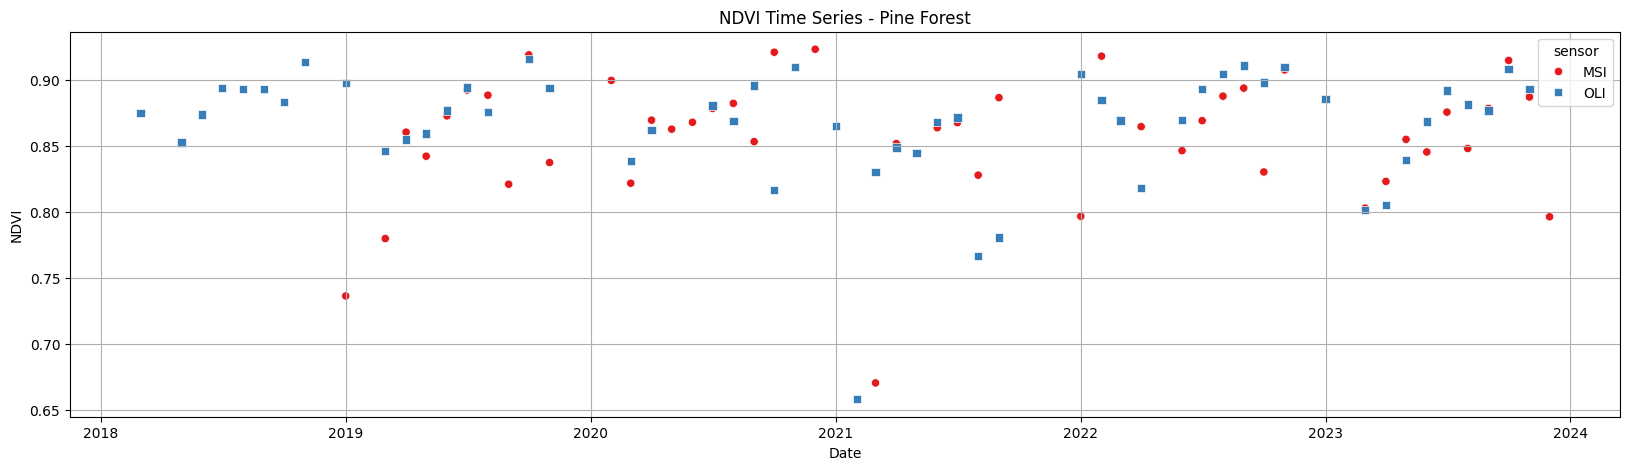

In [15]:
# Set figure size using Matplotlib
plt.rcParams['figure.figsize'] = [20, 5]

# Plot using Seaborn
sns.scatterplot(data=result_wa, x='date', y='ndvi', hue='sensor', palette='Set1', style='sensor', markers=['o', 's'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series - Pine Forest')

# Display the plot
plt.grid(True)
plt.show()

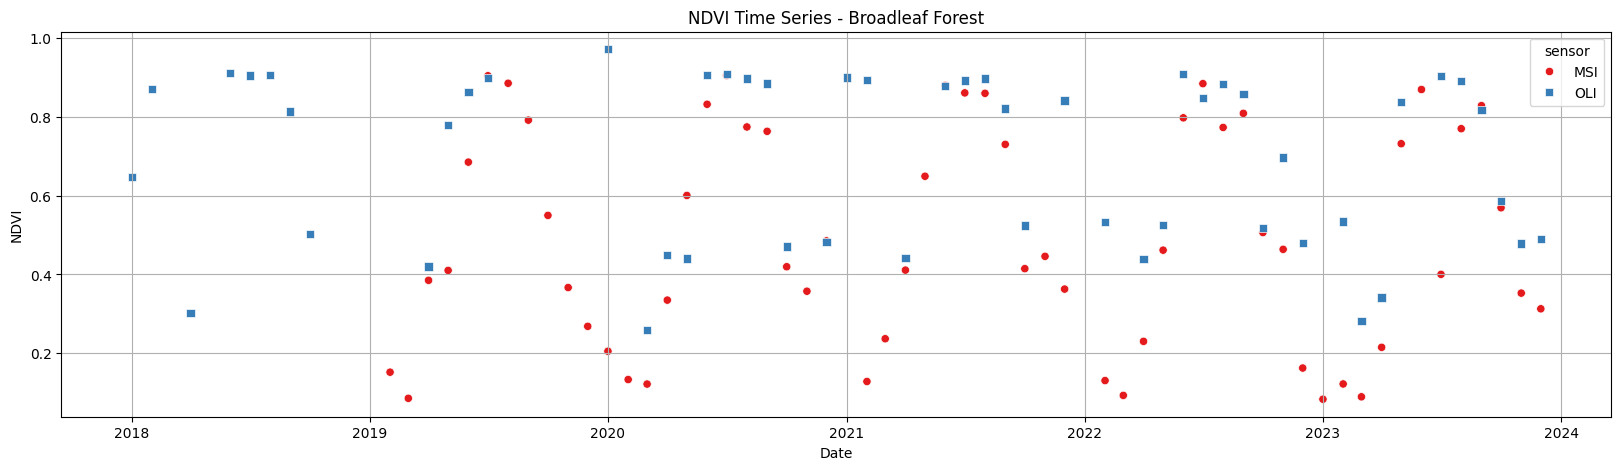

In [16]:
# Set figure size using Matplotlib
plt.rcParams['figure.figsize'] = [20, 5]

# Plot using Seaborn
sns.scatterplot(data=result_wi, x='date', y='ndvi', hue='sensor', palette='Set1', style='sensor', markers=['o', 's'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series - Broadleaf Forest')

# Display the plot
plt.grid(True)
plt.show()

## Combine Data Across Sensors

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_10659/844493884.py:9: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_avg_wa, x='date', y='ndvi', hue='sensor', palette='Set1', style='sensor', markers=['o', 's'])


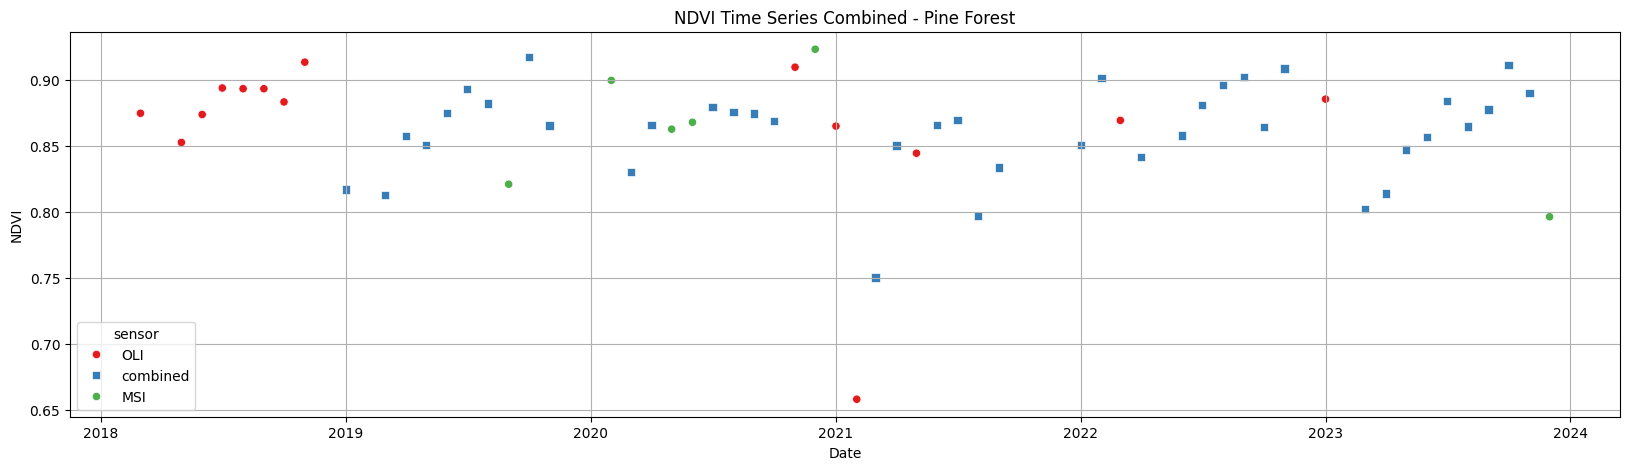

In [17]:
# Group by 'date', calculate mean of 'ndvi' and join 'sensor' values if there are multiple sensors
result_wa['sensor'] = result_wa.groupby('date')['sensor'].transform(lambda x: 'combined' if x.nunique() > 1 else x.iloc[0])
df_avg_wa = result_wa.groupby('date').agg({'ndvi': 'mean', 'sensor': 'first'}).reset_index()

# Set figure size using Matplotlib
plt.rcParams['figure.figsize'] = [20, 5]

# Plot using Seaborn
sns.scatterplot(data=df_avg_wa, x='date', y='ndvi', hue='sensor', palette='Set1', style='sensor', markers=['o', 's'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series Combined - Pine Forest')

# Display the plot
plt.grid(True)
plt.show()

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_10659/4163911634.py:9: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_avg_wi, x='date', y='ndvi', hue='sensor', palette='Set1', style='sensor', markers=['o', 's'])


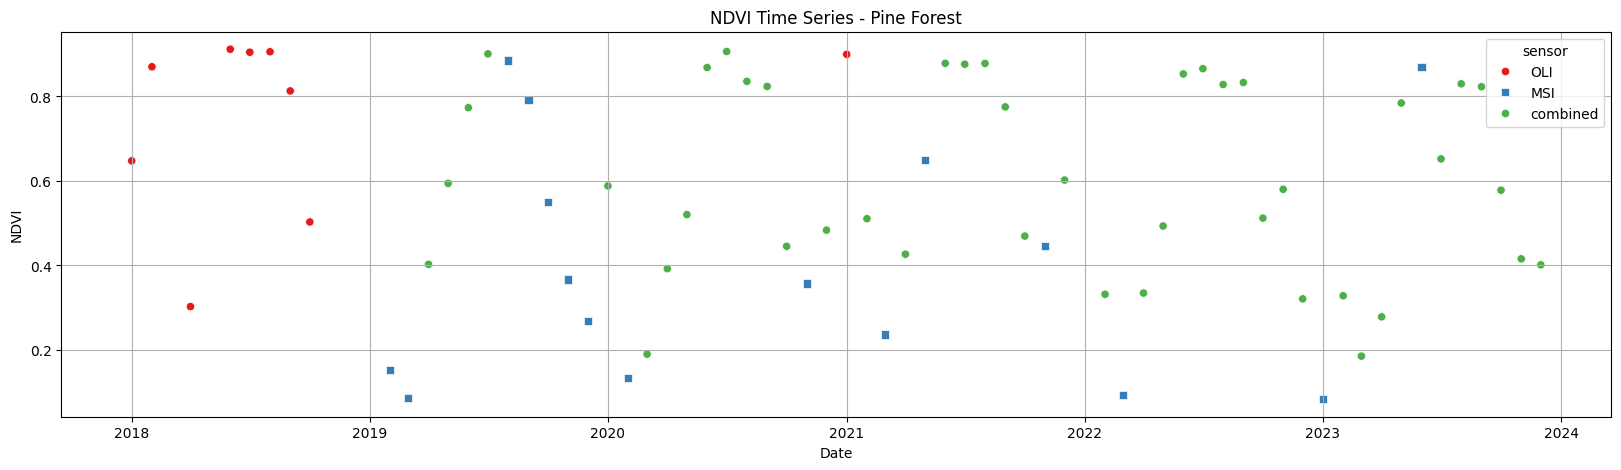

In [18]:
# Group by 'date', calculate mean of 'ndvi' and join 'sensor' values if there are multiple sensors
result_wi['sensor'] = result_wi.groupby('date')['sensor'].transform(lambda x: 'combined' if x.nunique() > 1 else x.iloc[0])
df_avg_wi = result_wi.groupby('date').agg({'ndvi': 'mean', 'sensor': 'first'}).reset_index()

# Set figure size using Matplotlib
plt.rcParams['figure.figsize'] = [20, 5]

# Plot using Seaborn
sns.scatterplot(data=df_avg_wi, x='date', y='ndvi', hue='sensor', palette='Set1', style='sensor', markers=['o', 's'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series - Broad Leaf Forest')

# Display the plot
plt.grid(True)
plt.show()

66